In [1]:
import os
import random
from pathlib import Path

import numpy as np
import torch

def set_seed(seed: int = 42):
    """Set global seed for reproducibility"""
    print(f"Setting global seed to {seed}")
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Try to make CuDNN behavior more deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1) Set seed for Python, NumPy, and PyTorch
SEED = 42
set_seed(SEED)

# 2) Define BASE_DIR
BASE_DIR = Path.cwd().parent
print("BASE_DIR:", BASE_DIR)

# 3) Check helmet.yaml file
data_config = BASE_DIR / "helmet.yaml"
print("helmet.yaml exists:", data_config.exists(), "| path:", data_config)

# 4) Check PyTorch & CUDA
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
else:
    print("⚠️ CUDA not detected. Please check your torch+cu121 installation.")


Setting global seed to 42
BASE_DIR: c:\dev\final_project_computer_vision
helmet.yaml exists: True | path: c:\dev\final_project_computer_vision\helmet.yaml
Torch version: 2.5.1+cu121
CUDA available: True
GPU device: NVIDIA GeForce RTX 4060


In [2]:
# ========== Cell 1.5: Verify and Fix Dataset Path ==========

import yaml

# Check if dataset exists
dataset_dir = BASE_DIR / "dataset_resplit_80_10_10"
val_images = dataset_dir / "val" / "images"

print("Checking dataset structure...")
print(f"Dataset directory: {dataset_dir}")
print(f"Dataset exists: {dataset_dir.exists()}")
print(f"Val images exist: {val_images.exists()}")
print()

if not val_images.exists():
    print("⚠️ Dataset not found at expected location!")
    print(f"   Expected: {dataset_dir}")
    print(f"   Please verify your dataset location.")
else:
    print("     Dataset found!")
    
    # Count images in each split
    for split in ['train', 'val', 'test']:
        split_path = dataset_dir / split / "images"
        if split_path.exists():
            count = len(list(split_path.glob("*.jpg"))) + len(list(split_path.glob("*.png")))
            print(f"   {split.upper():<6}: {count} images")
    
    print()
    
    # Update helmet.yaml with ABSOLUTE path to avoid confusion
    print("Updating helmet.yaml with absolute path...")
    
    corrected_yaml = {
        'path': str(dataset_dir).replace('\\', '/'),  # Use forward slashes for cross-platform
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': 2,
        'names': ['Helmet', 'No Helmet']
    }
    
    # Write corrected YAML
    with open(data_config, 'w') as f:
        yaml.dump(corrected_yaml, f, default_flow_style=False, sort_keys=False)
    
    print(f"    helmet.yaml updated!")
    print(f"    New path: {corrected_yaml['path']}")
    print()
    
    # Verify the updated YAML
    print("Verifying updated helmet.yaml:")
    with open(data_config, 'r') as f:
        print(f.read())


Checking dataset structure...
Dataset directory: c:\dev\final_project_computer_vision\dataset_resplit_80_10_10
Dataset exists: True
Val images exist: True

     Dataset found!
   TRAIN : 2988 images
   VAL   : 373 images
   TEST  : 374 images

Updating helmet.yaml with absolute path...
    helmet.yaml updated!
    New path: c:/dev/final_project_computer_vision/dataset_resplit_80_10_10

Verifying updated helmet.yaml:
path: c:/dev/final_project_computer_vision/dataset_resplit_80_10_10
train: train/images
val: val/images
test: test/images
nc: 2
names:
- Helmet
- No Helmet



## Experiment 1: Config B - No Augmentation (Baseline)

### Hypothesis
Since the dataset already contains extensive offline augmentations (rotation, shear, blur, mosaic), additional online augmentation may be redundant or create unrealistic over-augmented training examples.

### Rationale
- **Avoid double-augmentation**: Dataset already includes geometric transforms
- **Establish baseline**: Measure performance with pre-augmented data only
- **Test sufficiency**: Determine if 3,735 pre-augmented images provide enough variety

### Configuration
All YOLO online augmentation parameters disabled (set to 0.0):
- Color: `hsv_h`, `hsv_s`, `hsv_v`
- Geometric: `degrees`, `translate`, `scale`, `shear`, `perspective`
- Flip: `flipud`, `fliplr`
- Advanced: `mosaic`, `mixup`, `copy_paste`

---


In [ ]:
from ultralytics import YOLO

MODEL_NAME = "yolo11n.pt"
EXPERIMENT_NAME = "yolo11n_v2_resplit_no_aug"  # Changed name to reflect no augmentation
PROJECT_DIR = BASE_DIR / "runs" / "helmet"

EPOCHS = 80
IMG_SIZE = 640
BATCH_SIZE = 16
DEVICE = 0

# Initialize model
model = YOLO(MODEL_NAME)

print("\n" + "="*60)
print(" Training with PRE-AUGMENTED dataset")
print(" YOLO augmentations are DISABLED to prevent double-augmentation")
print("="*60 + "\n")

# Train with ALL augmentations disabled
results = model.train(
    data=str(data_config),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE,
    project=str(PROJECT_DIR),
    name=EXPERIMENT_NAME,
    seed=SEED,
    plots=True,
    patience=15,  # Early stopping if no improvement for 15 epochs
    
    # ========== DISABLE ALL YOLO AUGMENTATIONS ==========
    # (Dataset is already augmented by Roboflow)
    hsv_h=0.0,        # Disable hue augmentation
    hsv_s=0.0,        # Disable saturation augmentation
    hsv_v=0.0,        # Disable brightness augmentation
    degrees=0.0,      # Disable rotation (Roboflow: ±30°)
    translate=0.0,    # Disable translation
    scale=0.0,        # Disable scaling
    shear=0.0,        # Disable shear (Roboflow: ±15°)
    perspective=0.0,  # Disable perspective transform
    flipud=0.0,       # Disable vertical flip
    fliplr=0.0,       # Disable horizontal flip
    mosaic=0.0,       # Disable mosaic (Roboflow: applied)
    mixup=0.0,        # Disable mixup
    copy_paste=0.0,   # Disable copy-paste augmentation
)

print(f"\n Training complete!")
print(f"   Results saved to: {results.save_dir}")



 Training with PRE-AUGMENTED dataset
 YOLO augmentations are DISABLED to prevent double-augmentation

Ultralytics 8.3.235  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\dev\final_project_computer_vision\helmet.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=yolo11n_

In [7]:
# ========== Cell 3: Evaluate on Test Set ==========

from pathlib import Path
from ultralytics import YOLO
import json

# Load best model weights (not last epoch)
run_dir = Path(results.save_dir)
best_path = run_dir / "weights" / "best.pt"

print("\n" + "="*60)
print("Loading Best Model for Evaluation")
print("="*60)
print(f"Best weights: {best_path}")
print(f"Exists: {best_path.exists()}\n")

best_model = YOLO(str(best_path))

# Evaluate on test split
print("="*60)
print("Evaluating on TEST SET (Config: No Augmentation)")
print("="*60 + "\n")

test_metrics = best_model.val(
    data=str(data_config),
    split="test",
    imgsz=IMG_SIZE,
    device=DEVICE,
)

# Print test metrics
print("\n" + "="*60)
print("TEST SET PERFORMANCE - No Augmentation")
print("="*60)
print(f"mAP50      : {test_metrics.box.map50:.4f}")
print(f"mAP50-95   : {test_metrics.box.map:.4f}")
print(f"Precision  : {test_metrics.box.mp:.4f}")
print(f"Recall     : {test_metrics.box.mr:.4f}")
print("="*60 + "\n")

# Save metrics to JSON for later comparison
test_results = {
    'config': 'no_augmentation',
    'experiment_name': EXPERIMENT_NAME,
    'mAP50': float(test_metrics.box.map50),
    'mAP50_95': float(test_metrics.box.map),
    'precision': float(test_metrics.box.mp),
    'recall': float(test_metrics.box.mr)
}

metrics_path = run_dir / "test_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(test_results, f, indent=2)

print(f"Test metrics saved to: {metrics_path}")



Loading Best Model for Evaluation
Best weights: C:\dev\final_project_computer_vision\runs\helmet\yolo11n_v2_resplit_no_aug2\weights\best.pt
Exists: True

Evaluating on TEST SET (Config: No Augmentation)

Ultralytics 8.3.235  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 399.8118.2 MB/s, size: 32.2 KB)
val: Scanning C:\dev\final_project_computer_vision\dataset_resplit_80_10_10\test\labels.cache... 374 images, 10 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 374/374  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 7.9it/s 3.0s0.1s
                   all        374       1616      0.816      0.692      0.774      0.474
                Helmet        336       1147      0.867      0.736      0.832      0.524
             No Helmet        207        469      0.765     

# Experiment 2

In [3]:
from ultralytics import YOLO

MODEL_NAME = "yolo11n.pt"   # small model
EXPERIMENT_NAME = "yolo11n_v2_resplit_light_aug"  
PROJECT_DIR = BASE_DIR / "runs" / "helmet"

EPOCHS = 80
IMG_SIZE = 640
BATCH_SIZE = 16
DEVICE = 0 if torch.cuda.is_available() else "cpu"

print("\n" + "="*60)
print(" EXPERIMENT 2: YOLO11n + LIGHT AUGMENTATION")
print("="*60 + "\n")

# 5) INITIALIZE MODEL
model = YOLO(MODEL_NAME)

# 6) TRAIN WITH LIGHT AUGMENTATION
results = model.train(
    data=str(data_config),   # <- assumes helmet.yaml already fixed & loaded
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE,
    project=str(PROJECT_DIR),  # ../runs/helmet
    name=EXPERIMENT_NAME,      # yolo11n_v2_resplit_light_aug
    seed=SEED,                 # from earlier cell
    plots=True,
    patience=15,

    # 🔻 LIGHT AUGMENTATION
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,

    degrees=5.0,
    translate=0.1,
    scale=0.1,
    shear=2.0,
    perspective=0.0,

    flipud=0.0,
    fliplr=0.5,

    mosaic=0.0,
    mixup=0.0,
    copy_paste=0.0,
)

print("\nTraining complete!")
print("Saved to:", results.save_dir)


WARNING Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\Jeremy\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

 EXPERIMENT 2: YOLO11n + LIGHT AUGMENTATION

Ultralytics 8.3.235  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\dev\final_project_computer_vision\helmet.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, e

In [4]:
# ========== Cell 3: Evaluate on Test Set (Light Augmentation) ==========

from pathlib import Path
from ultralytics import YOLO
import json

# Load best model weights (not last epoch)
run_dir = Path(results.save_dir)          # this is yolo11n_v2_resplit_light_aug
best_path = run_dir / "weights" / "best.pt"

print("\n" + "="*60)
print("Loading Best Model for Evaluation")
print("="*60)
print(f"Best weights: {best_path}")
print(f"Exists: {best_path.exists()}\n")

best_model = YOLO(str(best_path))

# Evaluate on test split
print("="*60)
print("Evaluating on TEST SET (Config: Light Augmentation)")
print("="*60 + "\n")

test_metrics = best_model.val(
    data=str(data_config),
    split="test",
    imgsz=IMG_SIZE,
    device=DEVICE,
)

# Print test metrics
print("\n" + "="*60)
print("TEST SET PERFORMANCE - Light Augmentation")
print("="*60)
print(f"mAP50      : {test_metrics.box.map50:.4f}")
print(f"mAP50-95   : {test_metrics.box.map:.4f}")
print(f"Precision  : {test_metrics.box.mp:.4f}")
print(f"Recall     : {test_metrics.box.mr:.4f}")
print("="*60 + "\n")

# Save metrics to JSON for later comparison
test_results = {
    'config': 'light_augmentation',
    'experiment_name': EXPERIMENT_NAME,  # "yolo11n_v2_resplit_light_aug"
    'mAP50': float(test_metrics.box.map50),
    'mAP50_95': float(test_metrics.box.map),
    'precision': float(test_metrics.box.mp),
    'recall': float(test_metrics.box.mr)
}

metrics_path = run_dir / "test_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(test_results, f, indent=2)

print(f"Test metrics saved to: {metrics_path}")



Loading Best Model for Evaluation
Best weights: C:\dev\final_project_computer_vision\runs\helmet\yolo11n_v2_resplit_light_aug\weights\best.pt
Exists: True

Evaluating on TEST SET (Config: Light Augmentation)

Ultralytics 8.3.235  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 66.38.2 MB/s, size: 31.5 KB)
val: Scanning C:\dev\final_project_computer_vision\dataset_resplit_80_10_10\test\labels.cache... 374 images, 10 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 374/374 371.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 6.9it/s 3.5s0.1s
                   all        374       1616      0.917      0.826      0.903       0.56
                Helmet        336       1147      0.936      0.861      0.927      0.609
             No Helmet        207        469    

# Experiment 3

In [5]:
from ultralytics import YOLO
import torch
from pathlib import Path

MODEL_NAME = "yolo11s.pt"
EXPERIMENT_NAME = "exp3_yolo11s_v2_resplit_light_aug"
PROJECT_DIR = BASE_DIR / "runs" / "helmet"

EPOCHS = 80
IMG_SIZE = 640
BATCH_SIZE = 16
DEVICE = 0 if torch.cuda.is_available() else "cpu"

print("\n" + "="*60)
print(" EXPERIMENT 3: YOLO11s + LIGHT AUGMENTATION")
print("="*60 + "\n")

# Initialize larger model
model = YOLO(MODEL_NAME)

# Train with SAME light augmentation as Exp2
results = model.train(
    data=str(data_config),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE,
    project=str(PROJECT_DIR),
    name=EXPERIMENT_NAME,
    seed=SEED,
    plots=True,
    patience=15,

    # 🔁 SAME AUG AS EXP2
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,

    degrees=5.0,
    translate=0.1,
    scale=0.1,
    shear=2.0,
    perspective=0.0,

    flipud=0.0,
    fliplr=0.5,

    mosaic=0.0,
    mixup=0.0,
    copy_paste=0.0,
)

print("\nTraining complete!")
print("Saved to:", results.save_dir)



 EXPERIMENT 3: YOLO11s + LIGHT AUGMENTATION

Ultralytics 8.3.235  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\dev\final_project_computer_vision\helmet.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=exp3_yolo11s_v2_resplit_light_aug, nbs=64, nms=False, opset=Non

In [6]:
# ========== Cell 3: Evaluate on Test Set (YOLO11s + Light Aug) ==========

from pathlib import Path
from ultralytics import YOLO
import json

# Load best model weights (not last epoch)
run_dir = Path(results.save_dir)          # should be exp3_yolo11s_v2_resplit_light_aug
best_path = run_dir / "weights" / "best.pt"

print("\n" + "="*60)
print("Loading Best Model for Evaluation (YOLO11s)")
print("="*60)
print(f"Best weights: {best_path}")
print(f"Exists: {best_path.exists()}\n")

best_model = YOLO(str(best_path))

# Evaluate on test split
print("="*60)
print("Evaluating on TEST SET (Config: YOLO11s + Light Augmentation)")
print("="*60 + "\n")

test_metrics = best_model.val(
    data=str(data_config),
    split="test",
    imgsz=IMG_SIZE,
    device=DEVICE,
)

# Print test metrics
print("\n" + "="*60)
print("TEST SET PERFORMANCE - YOLO11s Light Augmentation")
print("="*60)
print(f"mAP50      : {test_metrics.box.map50:.4f}")
print(f"mAP50-95   : {test_metrics.box.map:.4f}")
print(f"Precision  : {test_metrics.box.mp:.4f}")
print(f"Recall     : {test_metrics.box.mr:.4f}")
print("="*60 + "\n")

# Save metrics to JSON for later comparison
test_results = {
    'config': 'yolo11s_light_augmentation',
    'experiment_name': EXPERIMENT_NAME,  # "exp3_yolo11s_v2_resplit_light_aug"
    'mAP50': float(test_metrics.box.map50),
    'mAP50_95': float(test_metrics.box.map),
    'precision': float(test_metrics.box.mp),
    'recall': float(test_metrics.box.mr)
}

metrics_path = run_dir / "test_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(test_results, f, indent=2)

print(f"Test metrics saved to: {metrics_path}")



Loading Best Model for Evaluation (YOLO11s)
Best weights: C:\dev\final_project_computer_vision\runs\helmet\exp3_yolo11s_v2_resplit_light_aug\weights\best.pt
Exists: True

Evaluating on TEST SET (Config: YOLO11s + Light Augmentation)

Ultralytics 8.3.235  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 84.842.0 MB/s, size: 31.1 KB)
val: Scanning C:\dev\final_project_computer_vision\dataset_resplit_80_10_10\test\labels.cache... 374 images, 10 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 374/374 373.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 4.1it/s 5.8s0.2s
                   all        374       1616      0.922      0.836       0.91      0.577
                Helmet        336       1147      0.948      0.861       0.94      0.628
             No Helme

# Evaluation

In [7]:
from pathlib import Path
from ultralytics import YOLO
import json
import math

# Common settings
IMG_SIZE = 640
DEVICE = 0 if torch.cuda.is_available() else "cpu"

EXPERIMENTS = [
    {
        "id": "Exp1_YOLO11n_no_aug",
        "run_dir": BASE_DIR / "runs" / "helmet" / "yolo11n_v2_resplit_no_aug2",
        "config": "no_augmentation",
    },
    {
        "id": "Exp2_YOLO11n_light_aug",
        "run_dir": BASE_DIR / "runs" / "helmet" / "yolo11n_v2_resplit_light_aug",
        "config": "light_augmentation",
    },
    {
        "id": "Exp3_YOLO11s_light_aug",
        "run_dir": BASE_DIR / "runs" / "helmet" / "exp3_yolo11s_v2_resplit_light_aug",
        "config": "yolo11s_light_augmentation",
    },
]

all_results = []

for exp in EXPERIMENTS:
    run_dir = exp["run_dir"]
    best_path = run_dir / "weights" / "best.pt"

    print("\n" + "="*70)
    print(f"Evaluating {exp['id']}")
    print("="*70)
    print("Best weights:", best_path)
    print("Exists:", best_path.exists(), "\n")

    if not best_path.exists():
        print("⚠️ Skipping, best.pt not found.\n")
        continue

    model = YOLO(str(best_path))

    test_metrics = model.val(
        data=str(data_config),
        split="test",
        imgsz=IMG_SIZE,
        device=DEVICE,
    )

    # Main metrics
    mAP50 = float(test_metrics.box.map50)
    mAP5095 = float(test_metrics.box.map)
    precision = float(test_metrics.box.mp)
    recall = float(test_metrics.box.mr)

    # Speed metrics (ms per image)
    speed = test_metrics.speed  # dict: preprocess, inference, loss, postprocess
    pre_ms = float(speed.get("preprocess", 0.0))
    inf_ms = float(speed.get("inference", 0.0))
    post_ms = float(speed.get("postprocess", 0.0))
    total_ms = pre_ms + inf_ms + post_ms
    fps = 1000.0 / total_ms if total_ms > 0 else math.nan

    print("\n--- TEST SET PERFORMANCE ---")
    print(f"mAP50        : {mAP50:.4f}")
    print(f"mAP50-95     : {mAP5095:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"Inference ms : {inf_ms:.2f} ms")
    print(f"Total ms/img : {total_ms:.2f} ms (≈ {fps:.1f} FPS)")
    print("-----------------------------\n")

    result_entry = {
        "id": exp["id"],
        "config": exp["config"],
        "run_dir": str(run_dir),
        "mAP50": mAP50,
        "mAP50_95": mAP5095,
        "precision": precision,
        "recall": recall,
        "pre_ms": pre_ms,
        "inf_ms": inf_ms,
        "post_ms": post_ms,
        "total_ms": total_ms,
        "fps": fps,
    }
    all_results.append(result_entry)

# Save JSON summary
summary_path = BASE_DIR / "runs" / "helmet" / "comparison_test_metrics.json"
with open(summary_path, "w") as f:
    json.dump(all_results, f, indent=2)

print("All experiment metrics saved to:", summary_path)

# -------- Pretty printed comparison table --------
if all_results:
    print("\n=== COMPARISON TABLE (TEST SET) ===")
    header = (
        f"{'ID':28} | {'mAP50':6} | {'mAP50-95':8} | "
        f"{'Prec':6} | {'Rec':6} | {'Inf ms':6} | {'Tot ms':6} | {'FPS':6}"
    )
    print(header)
    print("-" * len(header))
    for r in all_results:
        print(
            f"{r['id']:28} | "
            f"{r['mAP50']:.4f} | {r['mAP50_95']:.4f} | "
            f"{r['precision']:.4f} | {r['recall']:.4f} | "
            f"{r['inf_ms']:.2f} | {r['total_ms']:.2f} | {r['fps']:.1f}"
        )



Evaluating Exp1_YOLO11n_no_aug
Best weights: c:\dev\final_project_computer_vision\runs\helmet\yolo11n_v2_resplit_no_aug2\weights\best.pt
Exists: True 

Ultralytics 8.3.235  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 615.0179.6 MB/s, size: 32.2 KB)
val: Scanning C:\dev\final_project_computer_vision\dataset_resplit_80_10_10\test\labels.cache... 374 images, 10 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 374/374 373.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 6.1it/s 4.0s0.1s
                   all        374       1616      0.816      0.692      0.774      0.474
                Helmet        336       1147      0.867      0.736      0.832      0.524
             No Helmet        207        469      0.765      0.648      0.715      0.423
Speed: 3.1ms 

## Model Comparison and Evaluation

Three experiments were conducted to analyze the effect of augmentation and model size on helmet detection performance. Each model was trained and evaluated using the same dataset and test split to ensure a fair comparison.

### Test Set Results

| Model                              | Augmentation | mAP50  | mAP50–95 | Precision | Recall | Total Latency (ms) | FPS       |
| ---------------------------------- | ------------ | ------ | -------- | --------- | ------ | ------------------ | --------- |
| Exp1: YOLO11n (No Augmentation)    | None         | 0.7737 | 0.4736   | 0.8160    | 0.6920 | 7.48 ms            | 133.8 FPS |
| Exp2: YOLO11n (Light Augmentation) | Light        | 0.9027 | 0.5601   | 0.9169    | 0.8255 | 5.30 ms            | 188.8 FPS |
| Exp3: YOLO11s (Light Augmentation) | Light        | 0.9096 | 0.5774   | 0.9225    | 0.8358 | 7.87 ms            | 127.1 FPS |

---

## Analysis and Insights

### 1. Effect of Augmentation

Comparing Exp1 and Exp2 shows that applying light augmentation significantly improves performance. YOLO11n with augmentation achieves higher mAP, precision, and recall, indicating better generalization to variations in the data. Without augmentation, the model underperforms and shows signs of underfitting.

### 2. Effect of Model Size

Exp3 demonstrates that YOLO11s provides higher accuracy than YOLO11n, even when using the same augmentation settings. The larger model achieves the best mAP50, precision, and recall. This suggests that the additional model capacity of YOLO11s allows it to capture more complex features in the dataset.

### 3. Speed Considerations

YOLO11n-light is the fastest model, achieving nearly 189 FPS, while YOLO11s-light runs at about 127 FPS. Both are well above real-time requirements. YOLO11n-light is more suitable for resource-limited hardware, but YOLO11s-light offers better accuracy at a modest cost in speed.

### 4. Trade-off Summary

All models are capable of real-time inference for CCTV monitoring. The choice between models depends on whether accuracy or speed is the primary priority. YOLO11s-light is the most accurate and remains fast enough for real-time use. YOLO11n-light offers high speed with slightly lower accuracy.

---

## Selected Model

The recommended model is **YOLO11s with light augmentation (Exp3)**.
It provides:

* The highest accuracy across all metrics
* The best recall, reducing missed detections
* Sufficient inference speed for real-time CCTV applications
* More reliable performance under varying conditions

Although YOLO11n-light is faster, YOLO11s-light achieves a better balance between accuracy and speed, making it the most suitable model for practical deployment.


## Plotting Evaluation

Loaded metrics for models:
                    Model     mAP50  mAP50_95  precision    recall         fps
0     Exp1_YOLO11n_no_aug  0.773728  0.473638   0.815971  0.692010  133.774005
1  Exp2_YOLO11n_light_aug  0.902711  0.560066   0.916875  0.825529  188.775976
2  Exp3_YOLO11s_light_aug  0.909610  0.577404   0.922450  0.835806  127.139643


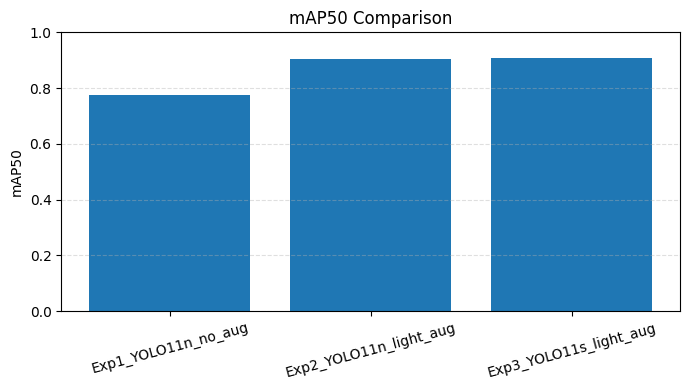

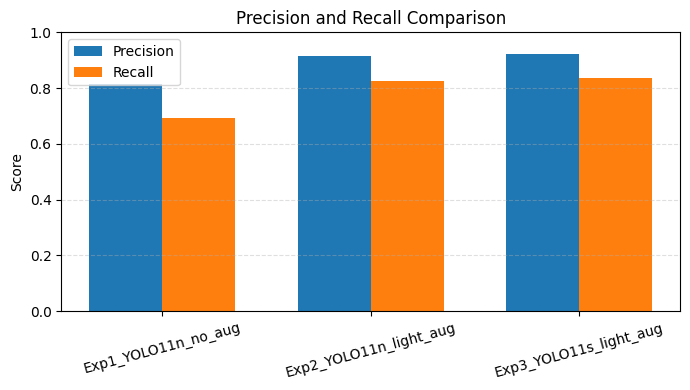

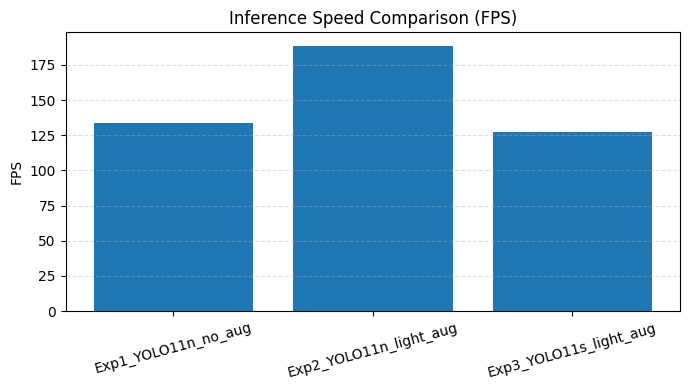

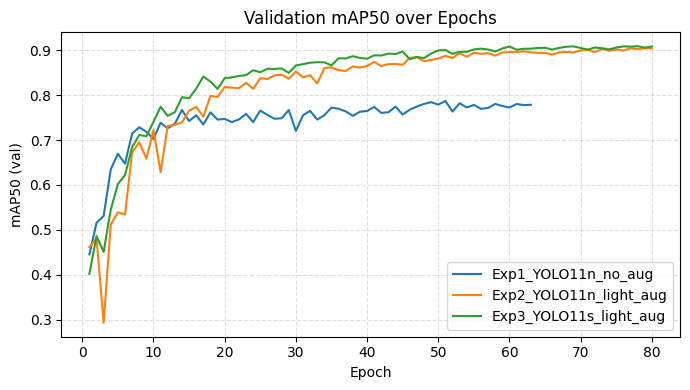

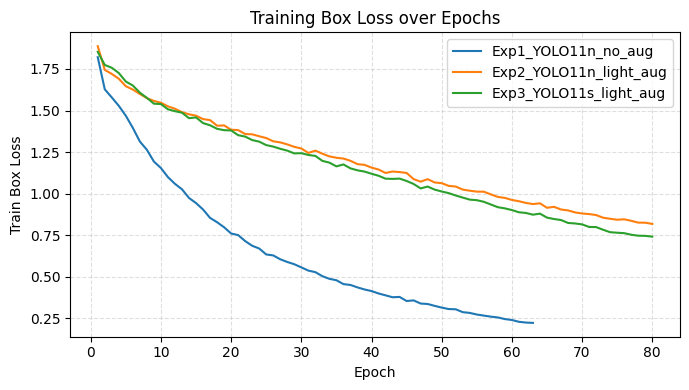

In [11]:
import json
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Load metrics
summary_path = BASE_DIR / "runs" / "helmet" / "comparison_test_metrics.json"
with open(summary_path, "r") as f:
    results = json.load(f)

df = pd.DataFrame(results)
df["Model"] = df["id"]

print("Loaded metrics for models:")
print(df[["Model", "mAP50", "mAP50_95", "precision", "recall", "fps"]])

# 1. mAP50 Plot
plt.figure(figsize=(7, 4))
plt.bar(df["Model"], df["mAP50"])
plt.title("mAP50 Comparison")
plt.ylabel("mAP50")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 2. Precision vs Recall
plt.figure(figsize=(7, 4))
width = 0.35
x = range(len(df))

plt.bar([p - width/2 for p in x], df["precision"], width=width, label="Precision")
plt.bar([p + width/2 for p in x], df["recall"],    width=width, label="Recall")

plt.xticks(list(x), df["Model"], rotation=15)
plt.ylabel("Score")
plt.title("Precision and Recall Comparison")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 3. FPS Plot
plt.figure(figsize=(7, 4))
plt.bar(df["Model"], df["fps"])
plt.title("Inference Speed Comparison (FPS)")
plt.ylabel("FPS")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 4. Training Plot
runs = {
    "Exp1_YOLO11n_no_aug": BASE_DIR / "runs" / "helmet" / "yolo11n_v2_resplit_no_aug2",
    "Exp2_YOLO11n_light_aug": BASE_DIR / "runs" / "helmet" / "yolo11n_v2_resplit_light_aug",
    "Exp3_YOLO11s_light_aug": BASE_DIR / "runs" / "helmet" / "exp3_yolo11s_v2_resplit_light_aug",
}

# 1. Validation mAP50 over epochs
plt.figure(figsize=(7, 4))
for label, run_dir in runs.items():
    csv_path = run_dir / "results.csv"
    df_run = pd.read_csv(csv_path)
    # Ultralytics uses these column names for val mAP50
    plt.plot(df_run["epoch"], df_run["metrics/mAP50(B)"], label=label)

plt.xlabel("Epoch")
plt.ylabel("mAP50 (val)")
plt.title("Validation mAP50 over Epochs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Training box loss over epochs
plt.figure(figsize=(7, 4))
for label, run_dir in runs.items():
    csv_path = run_dir / "results.csv"
    df_run = pd.read_csv(csv_path)
    plt.plot(df_run["epoch"], df_run["train/box_loss"], label=label)

plt.xlabel("Epoch")
plt.ylabel("Train Box Loss")
plt.title("Training Box Loss over Epochs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


## Confusion Matrix

Loading model from: c:\dev\final_project_computer_vision\runs\helmet\exp3_yolo11s_v2_resplit_light_aug\weights\best.pt
Ultralytics 8.3.235  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 294.0196.8 MB/s, size: 29.5 KB)
val: Scanning C:\dev\final_project_computer_vision\dataset_resplit_80_10_10\test\labels.cache... 374 images, 10 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 374/374 376.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 5.6it/s 4.3s0.1s
                   all        374       1616      0.922      0.836       0.91      0.577
                Helmet        336       1147      0.948      0.861       0.94      0.628
             No Helmet        207        469      0.897       0.81       0.88      0.527
Speed: 1.9ms preprocess, 6.1ms inference, 0.0m

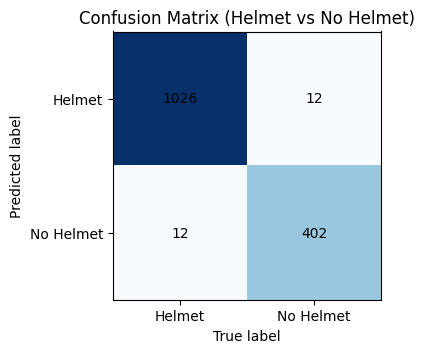

In [13]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np

# 1. Load best model (Exp3 YOLO11s + light augmentation)
best_model_path = (
    BASE_DIR
    / "runs"
    / "helmet"
    / "exp3_yolo11s_v2_resplit_light_aug"
    / "weights"
    / "best.pt"
)

print("Loading model from:", best_model_path)
model = YOLO(str(best_model_path))

# 2. Run validation ONCE with plots=True so confusion matrix is computed
metrics = model.val(
    data=str(data_config),
    split="test",
    imgsz=IMG_SIZE,
    device=DEVICE,
    plots=True   # important: ensures confusion_matrix.matrix is filled
)

# 3. Get full confusion matrix (last row/col = background)
cm_full = metrics.confusion_matrix.matrix  # numpy array
print("Full confusion matrix shape:", cm_full.shape)
print(cm_full)

# 4. Remove background row/column: keep only real classes
#    This drops the last row and last column.
cm_2x2 = cm_full[:-1, :-1]

labels = ["Helmet", "No Helmet"]

# 5. Plot 2×2 confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm_2x2, cmap="Blues")

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.set_xlabel("True label")
ax.set_ylabel("Predicted label")
ax.set_title("Confusion Matrix (Helmet vs No Helmet)")

# Annotate counts
for i in range(cm_2x2.shape[0]):
    for j in range(cm_2x2.shape[1]):
        ax.text(
            j, i,
            int(cm_2x2[i, j]),
            ha="center",
            va="center",
            color="black"
        )

plt.tight_layout()
plt.show()


# Inference Test

Running Inference on Sample Test Images (YOLO11s + Light Aug)

Loading model from: c:\dev\final_project_computer_vision\runs\helmet\exp3_yolo11s_v2_resplit_light_aug\weights\best.pt
Found 374 test images
Sampling 3 random images for visual inspection...

Image 1/3: BikesHelmets403_png_jpg.rf.ea7edfdecc1020fd03a68da509d243af.jpg

image 1/1 c:\dev\final_project_computer_vision\dataset_resplit_80_10_10\test\images\BikesHelmets403_png_jpg.rf.ea7edfdecc1020fd03a68da509d243af.jpg: 640x640 5 Helmets, 3 No Helmets, 62.3ms
Speed: 7.2ms preprocess, 62.3ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)


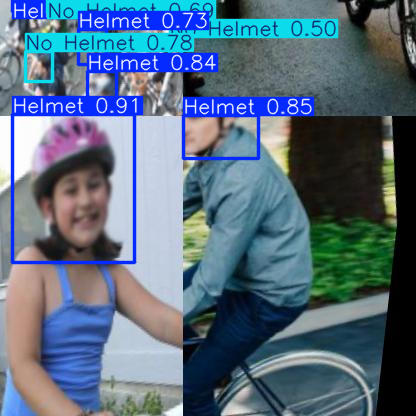


Image 2/3: BikesHelmets172_png_jpg.rf.87481b21a4d71086345657ea8939482a.jpg

image 1/1 c:\dev\final_project_computer_vision\dataset_resplit_80_10_10\test\images\BikesHelmets172_png_jpg.rf.87481b21a4d71086345657ea8939482a.jpg: 640x640 6 No Helmets, 50.0ms
Speed: 5.2ms preprocess, 50.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


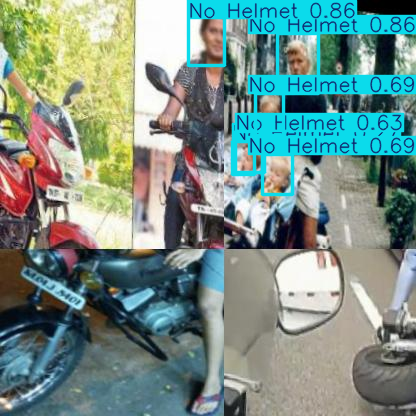


Image 3/3: BikesHelmets169_png_jpg.rf.e5053a3386fcdde5545b70349aaf44b0.jpg

image 1/1 c:\dev\final_project_computer_vision\dataset_resplit_80_10_10\test\images\BikesHelmets169_png_jpg.rf.e5053a3386fcdde5545b70349aaf44b0.jpg: 640x640 5 Helmets, 35.7ms
Speed: 3.7ms preprocess, 35.7ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


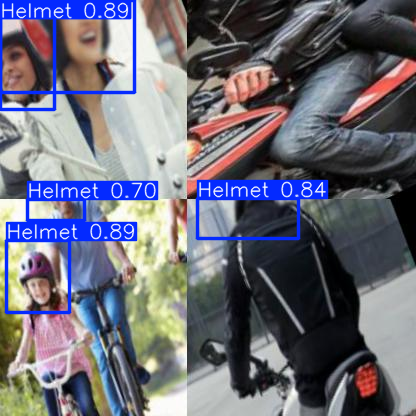

In [14]:
# ========== Cell 4: Inference on Sample Test Images (Final Model) ==========

from ultralytics import YOLO
from IPython.display import display
from PIL import Image as PILImage
from pathlib import Path
import random

print("="*60)
print("Running Inference on Sample Test Images (YOLO11s + Light Aug)")
print("="*60 + "\n")

# 1) Load final best model (Exp3 YOLO11s)
best_model_path = (
    BASE_DIR
    / "runs"
    / "helmet"
    / "exp3_yolo11s_v2_resplit_light_aug"
    / "weights"
    / "best.pt"
)
print("Loading model from:", best_model_path)

best_model = YOLO(str(best_model_path))

# 2) Collect test images
test_images_dir = BASE_DIR / "dataset_resplit_80_10_10" / "test" / "images"
test_images = list(test_images_dir.glob("*.jpg")) + list(test_images_dir.glob("*.png"))

if len(test_images) == 0:
    print(f"WARNING: No images found in {test_images_dir}")
else:
    print(f"Found {len(test_images)} test images")
    print("Sampling 3 random images for visual inspection...\n")

    sample_images = random.sample(test_images, min(3, len(test_images)))

    # 3) Run inference and display results
    for i, img_path in enumerate(sample_images, 1):
        print("=" * 60)
        print(f"Image {i}/3: {img_path.name}")
        print("=" * 60)

        results = best_model(
            source=str(img_path),
            conf=0.25,
            imgsz=IMG_SIZE,
            device=DEVICE,
        )

        # Plot results (results[0].plot() returns BGR numpy array)
        plotted = results[0].plot()
        img_rgb = PILImage.fromarray(plotted[:, :, ::-1])  # BGR -> RGB

        display(img_rgb)
        print()


# Save Model

In [15]:
import shutil
import json
import yaml
from pathlib import Path

# -----------------------------
# 1. Paths
# -----------------------------
exp3_run_dir = BASE_DIR / "runs" / "helmet" / "exp3_yolo11s_v2_resplit_light_aug"
best_ckpt = exp3_run_dir / "weights" / "best.pt"

models_dir = BASE_DIR / "models"
models_dir.mkdir(exist_ok=True)

# Final model filename for deployment
deploy_model_path = models_dir / "helmet_detector_yolo11s_v2.pt"

print("Source checkpoint:", best_ckpt)
print("Deploy path      :", deploy_model_path)

# -----------------------------
# 2. Copy best.pt → /models
# -----------------------------
shutil.copy(best_ckpt, deploy_model_path)
print("Model copied to:", deploy_model_path)

# -----------------------------
# 3. Load Exp3 metrics from comparison_test_metrics.json
# -----------------------------
summary_path = BASE_DIR / "runs" / "helmet" / "comparison_test_metrics.json"
with open(summary_path, "r") as f:
    all_results = json.load(f)

exp3_entry = None
for r in all_results:
    if r["id"] == "Exp3_YOLO11s_light_aug":
        exp3_entry = r
        break

if exp3_entry is None:
    raise ValueError("Exp3_YOLO11s_light_aug not found in comparison_test_metrics.json")

# -----------------------------
# 4. Load training args from args.yaml (optional but useful)
# -----------------------------
args_path = exp3_run_dir / "args.yaml"
if args_path.exists():
    with open(args_path, "r") as f:
        train_args = yaml.safe_load(f)
else:
    train_args = {}

# If args.yaml is huge and you want only key things, you can filter:
important_keys = ["epochs", "batch", "imgsz", "device", "optimizer", "lr0", "momentum", "weight_decay", "seed", "model"]
train_args_filtered = {k: train_args.get(k) for k in important_keys}

# -----------------------------
# 5. Build deployment config dict
# -----------------------------
deployment_config = {
    "experiment_id": "Exp3_YOLO11s_light_aug",
    "run_dir": str(exp3_run_dir),
    "model_path": str(deploy_model_path),

    # Model & data info
    "num_classes": 2,
    "class_names": ["Helmet", "No Helmet"],
    "imgsz": IMG_SIZE,
    "default_conf": 0.25,
    "default_iou": 0.45,

    # Test metrics (for documentation)
    "test_metrics": {
        "mAP50": exp3_entry["mAP50"],
        "mAP50_95": exp3_entry["mAP50_95"],
        "precision": exp3_entry["precision"],
        "recall": exp3_entry["recall"],
        "fps": exp3_entry["fps"],
    },

    # Training hyperparameters (subset)
    "train_args": train_args_filtered,
}

# -----------------------------
# 6. Save deployment config JSON next to the model
# -----------------------------
config_path = models_dir / "helmet_detector_yolo11s_v2_config.json"
with open(config_path, "w") as f:
    json.dump(deployment_config, f, indent=2)

print("Deployment config saved to:", config_path)


Source checkpoint: c:\dev\final_project_computer_vision\runs\helmet\exp3_yolo11s_v2_resplit_light_aug\weights\best.pt
Deploy path      : c:\dev\final_project_computer_vision\models\helmet_detector_yolo11s_v2.pt
Model copied to: c:\dev\final_project_computer_vision\models\helmet_detector_yolo11s_v2.pt
Deployment config saved to: c:\dev\final_project_computer_vision\models\helmet_detector_yolo11s_v2_config.json
